In [1]:
!pip install yfinance matplotlib langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.7 MB/s eta 0:00:00


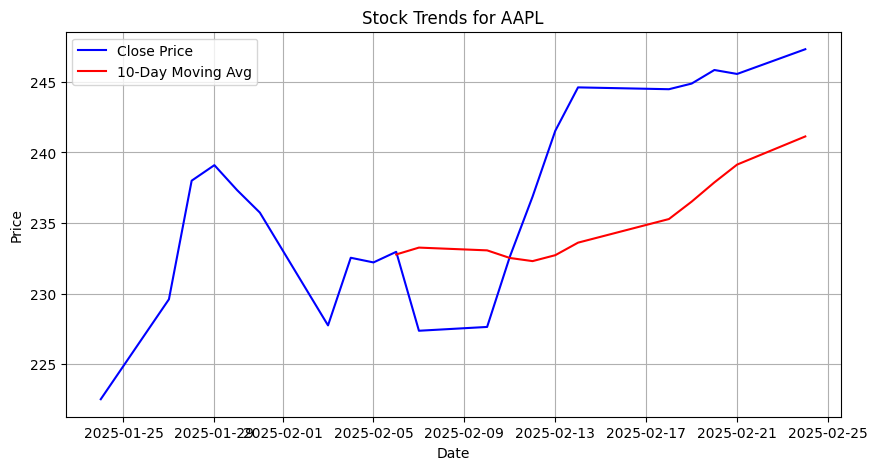

Analysis completed for AAPL


In [8]:
import yfinance as yf
import matplotlib.pyplot as plt
import langgraph
from langgraph.graph import StateGraph, END
from pydantic import BaseModel
import pandas as pd
from typing import Dict, Any, TypedDict

class StockStateDict(TypedDict):
    ticker: str
    period: str
    interval: str
    data: Dict[str, Any]

class StockState(BaseModel):
    ticker: str
    period: str = "1mo"
    interval: str = "1d"
    data: Dict[str, Any] = None

def fetch_stock_data(state: StockStateDict) -> StockStateDict:
    stock = yf.Ticker(state["ticker"])
    data = stock.history(period=state["period"], interval=state["interval"])
    state["data"] = data.to_dict()
    return state

def analyze_stock_data(state: StockStateDict) -> StockStateDict:
    data = pd.DataFrame(state["data"])
    data["MA_10"] = data["Close"].rolling(window=10).mean()
    data["Volatility"] = data["Close"].pct_change().rolling(window=10).std()
    state["data"] = data.to_dict()
    return state

def plot_stock_data(state: StockStateDict) -> StockStateDict:
    data = pd.DataFrame(state["data"])
    ticker = state["ticker"]
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data["Close"], label="Close Price", color="blue")
    plt.plot(data.index, data["MA_10"], label="10-Day Moving Avg", color="red")
    plt.title(f"Stock Trends for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()
    return state

def build_graph():

    workflow = StateGraph(StockStateDict)

    workflow.add_node("fetch_data", fetch_stock_data)
    workflow.add_node("analyze_data", analyze_stock_data)
    workflow.add_node("plot_data", plot_stock_data)

    workflow.add_edge("fetch_data", "analyze_data")
    workflow.add_edge("analyze_data", "plot_data")
    workflow.add_edge("plot_data", END)

    workflow.set_entry_point("fetch_data")

    return workflow.compile()

def main():

    state = {
        "ticker": "AAPL",
        "period": "1mo",
        "interval": "1d",
        "data": None
    }

    graph = build_graph()
    final_state = graph.invoke(state)

    print(f"Analysis completed for {final_state['ticker']}")

if __name__ == "__main__":
    main()